In [1]:
# Important standard packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Importing packages used in data pre-processing
import gensim
from gensim.utils import simple_preprocess, tokenize
from gensim.parsing.preprocessing import STOPWORDS
import gensim.corpora as corpora
from nltk.stem.porter import *
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.corpus import stopwords
import string 
from tqdm import tqdm
from pprint import pprint
import time

# Preparing data
1. Loading data and dropping irrelevant columns
2. Removal of NaN values from relevant attributes
3. Create new dataframe consisting of only keywords and country ID

In [3]:
data=pd.read_csv("FAOLEX_ALL.csv")
# print(data.keys())
# print(df.info())
# print(keywords[:5])

# Create simplified version of the dataframe by discarding irrelevant columns 
to_drop = ['Record Id', 
           'Record URL', 
           'Document URL', 
           'Title',
           'Original title',
           'Available website',
           'Abstract']

data.drop(to_drop, inplace=True, axis=1)

In [4]:
# Remove NaN values in the Countries/Territory and Keywords attributes 
data_no_nan = data.dropna(subset=["Country/Territory", "Keywords"])
print(f"This results in {len(data) - len(data_no_nan)} rows being dropped")

This results in 939 rows being dropped


In [5]:
data_kw = data_no_nan[["Country/Territory","Keywords"]]
data_kw['index'] = data_kw.index
keywords = data_kw

/var/folders/sb/klhtpy1n7jd649__g8r7xj300000gn/T/ipykernel_30051/1041940241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_kw['index'] = data_kw.index


# Data pre-processing (v2)
**IMPORTANT**: This is the version of the data pre-processing that should be applied - do not use v1

In [6]:
tokenizer = RegexpTokenizer(r'\w+') # create tokenizer to tokenize docs 
stop_words = stopwords.words('english') # create list of stopwords
p_stemmer = PorterStemmer() # create stemmer instance 


In [7]:
doc_set = keywords["Keywords"].tolist()
processed_kw_list = []

# loop through document list
for i in tqdm(doc_set):
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in stop_words]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    processed_kw_list.append(stemmed_tokens)
    #processed_kw_list.append(stopped_tokens)
    


100%|██████████| 195498/195498 [00:28<00:00, 6924.63it/s]


# Data pre-processing (v1)
1. Create various pre-processing functions
2. Perform the pre-processing on the simplified dataframe created above
3. Stopwords removal
4. Lemmatization (yet to be done)

In [6]:
# Create function to remove punctuation from input text
def remove_punctuation(text):
    # signs = ";'-"
    signs = ";"
    #return "".join([i for i in text if i not in string.punctuation])
    
    return "".join([i for i in text if i not in signs])

'''
def remove_stop_words(text): 
    for word in text: 
        if word in stop_words: 
            text = text.replace(word, '')
    return text
'''


# Create function to do data pre-processing (excluding stop word removal and lemmatization)
def pre_process(text):
    text = remove_punctuation(text)
    # text = remove_stop_words(text)
    text = text.lower()
    processed = list(tokenize(text))
    
    return processed


In [7]:
# Performing pre-processsing 
processed_kw = keywords["Keywords"].map(pre_process)

# Convert to a list
processed_kw_list = processed_kw.values.tolist()

# Remove stop words
stop_words = stopwords.words('english')
for lists in processed_kw_list:
    for kw in lists: 
        if kw in stop_words:
            lists.remove(kw)

# Lemmatization 
# TODO figure out a way to do this 


# LDA model

In [8]:
# Mapping from word IDs to words
# https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920
id2word = corpora.Dictionary(processed_kw_list)

# Prepare Document-Term matrix
corpus = []
for doc in processed_kw_list:
    corpus.append(id2word.doc2bow(doc))

In [30]:
# Creating the LDA model
n_topics = 76
# Documentation: https://radimrehurek.com/gensim/models/ldamodel.html
'''
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, 
                                            id2word = id2word, 
                                            num_topics=n_topics, 
                                            random_state=100, 
                                            passes = 20)
'''
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus = corpus, 
                                            id2word = id2word, 
                                            num_topics=n_topics, 
                                            random_state=100, 
                                            passes = 50)


In [126]:
pprint(lda_model.print_topics())


[(0,
  '0.100*"fishing" + 0.097*"marine" + 0.067*"management" + 0.065*"fisheries" + '
  '0.063*"conservation" + 0.055*"fishery" + 0.029*"area" + 0.026*"fishes" + '
  '0.022*"authorization" + 0.021*"zone"'),
 (1,
  '0.056*"international" + 0.054*"trade" + 0.038*"collection" + '
  '0.038*"reporting" + 0.038*"data" + 0.037*"production" + '
  '0.035*"authorization" + 0.035*"permit" + 0.033*"plant" + 0.026*"internal"'),
 (2,
  '0.084*"land" + 0.038*"rights" + 0.034*"conservation" + 0.030*"protected" + '
  '0.030*"area" + 0.030*"planning" + 0.027*"protection" + 0.026*"use" + '
  '0.022*"wild" + 0.021*"indigenous"'),
 (3,
  '0.062*"forest" + 0.059*"management" + 0.044*"sustainable" + '
  '0.034*"conservation" + 0.033*"development" + 0.033*"public" + '
  '0.029*"protection" + 0.028*"planning" + 0.026*"climate" + 0.026*"change"'),
 (4,
  '0.122*"proceedings" + 0.072*"agricultural" + 0.061*"legal" + '
  '0.061*"administrative" + 0.053*"energy" + 0.046*"institution" + '
  '0.042*"development" + 0

In [31]:
# Compute Coherence Score (the higher the better)
coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=processed_kw_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.5384069144767277


In [82]:
# WARNING: takes potentially multiple hours to run!!! 
# Create function to find optimal topic_num to use in LDA model
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for topic_n in tqdm(range(start, limit, step)):
        # model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=topic_n, id2word=dictionary, random_state=100, passes = 5)
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=topic_n, id2word=dictionary, random_state=100, passes=5)
        model_list.append(model)
        coherencemodel = gensim.models.coherencemodel.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Trying to find optimal number of topics

In [75]:
# Finding the optimal number of topics by creating multiple LDA models and computing coherence score
dictionary = id2word
corpus = corpus
texts = processed_kw_list
limit = 300
start = 10
step = 10

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, limit=limit, start=start, step=step)

  0%|          | 0/29 [00:06<?, ?it/s]


KeyboardInterrupt: 

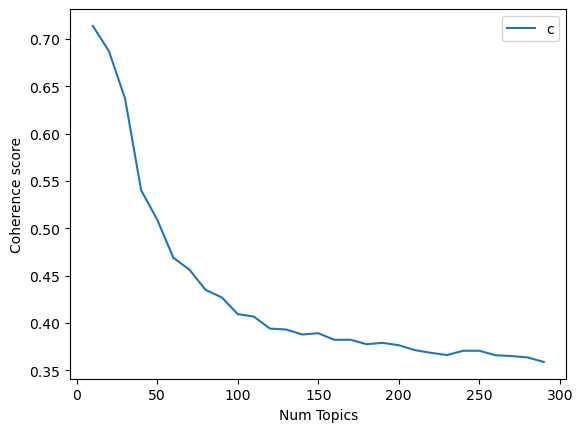

In [71]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [76]:
dictionary = id2word
corpus = corpus
texts = processed_kw_list
limit = 100
start = 70
step = 3

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, limit=limit, start=start, step=step)

100%|██████████| 10/10 [24:12<00:00, 145.22s/it]


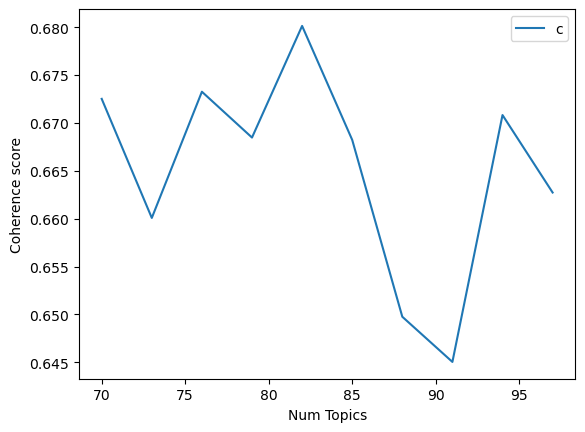

In [77]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [83]:
dictionary = id2word
corpus = corpus
texts = processed_kw_list
limit = 110 
start = 70
step = 2

models = []
coherences = []
for i in tqdm(range(3)): 
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, limit=limit, start=start, step=step)
    models.append(model_list)
    coherences.append(coherence_values)

100%|██████████| 3/3 [5:23:24<00:00, 6468.32s/it]  


In [105]:
# Fixes mistake made in above loop where coherence appended itself. The issue above has also been fixed, so this is only applicaple one time. 
models_copy = models.copy()
coherences = []
for run in tqdm(models_copy, desc="Outer", position=0):
    coherences_run = []
    for model in tqdm(run, desc=" Inner loop", position=1, leave=False): 
        time.sleep(0.05)
        coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=model, texts=processed_kw_list, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        coherences_run.append(coherence_lda)
    coherences.append(coherences_run)


Outer: 100%|██████████| 3/3 [10:24<00:00, 208.07s/it]


In [107]:
# Create list of average coherence values 
avg_coherence_values = []

for i in range(len(coherence_values)): 
    total_i = coherences[0][i] + coherences[1][i] + coherences[2][i]
    avg_i = total_i / 3
    avg_coherence_values.append(avg_i)

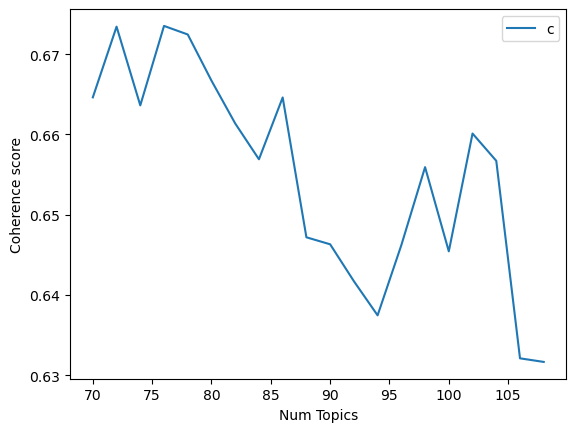

In [108]:
limit = 110 
start = 70
step = 2

x = range(start, limit, step)
plt.plot(x, avg_coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

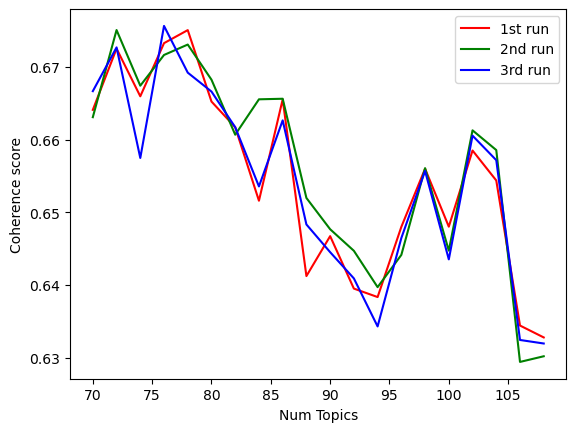

In [109]:
# Plot for each run 
limit = 110
start = 70
step = 2

x = range(start, limit, step)

# List of three lists
list1 = coherences[0]
list2 = coherences[1]
list3 = coherences[2]

# List of list names for the legend
list_names = ['1st run', '2nd run', '3rd run']

# List of colors for each list
colors = ['red', 'green', 'blue']

# Plot each list separately
for i, lst in enumerate([list1, list2, list3]):
    plt.plot(x, lst, color=colors[i])

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(list_names, loc='best')
plt.show()

# Co-occurence

In [32]:
# Create a list of countries 
all_countries = keywords["Country/Territory"].tolist()

#
countries_new=[]
for coun in all_countries:
    if len(coun.split(";"))>=2:
        for c in coun.split("; "):
            countries_new.append(c)
    else:
        countries_new.append(coun)

# Make country dict --> key: country, value: country index
countries = {}
i=0
for country_x in (list(set(countries_new))):
    countries[country_x]=i
    i+=1

In [33]:
topic_nums = np.arange(n_topics)

# topic sizes
topic_sizes = np.asarray(np.zeros(n_topics), dtype = 'int')

# list used to store all documents belonging to each individual topic 
documents_in_topics = [[] for _ in range(n_topics)]

for i in tqdm(range(len(corpus))): 
    topics = lda_model.get_document_topics(corpus[i])
    largest_prob = max(topics, key=lambda x: x[1])
    topic_max_prob = largest_prob[0]
    topic_sizes[topic_max_prob] += int(1)

    # fill out the list described above - to be used for further processing
    documents_in_topics[topic_max_prob].append((i, largest_prob[1]))




100%|██████████| 195498/195498 [00:22<00:00, 8848.04it/s]


In [34]:
# Sort the documents_in_topics list such that document with the highest probability of belonging to the respective topic
# is placed first in the corresponding sub-list. 

for sub_list in documents_in_topics:
    sub_list.sort(key=lambda x: x[1], reverse=True)

# Create a list as above without the probabilities (such that only the indices are used)
new_documents_in_topics = [[t[0] for t in sublist] for sublist in documents_in_topics]

In [35]:
# Compute country x topic occurence matrix
country_topic_matrix = np.zeros((len(set(countries_new)),len(topic_nums)))

for num in topic_nums:
    # For each topic get the corresponding documents
    document_ids = new_documents_in_topics[num]
    for id in document_ids:
        # Find the documents' countries and add it to the co-occurence matrix
        if len(all_countries[id].split(";"))>=2:
            for c in all_countries[id].split("; "):
                 country_topic_matrix[countries[c],num] +=1
        else:
            country_topic_matrix[countries[all_countries[id]],num] +=1

In [36]:
# Relevant function used in the next section
def square_rooted(x):
   return round(np.sqrt(sum([a*a for a in x])),3)

def get_swap_dict(d):
    return {v: k for k, v in d.items()}

countries_swap = get_swap_dict(countries)

In [37]:
def co_occurence(country_new, similarity):
    country_co_occurrence = np.zeros((len(set(country_new)),len(set(country_new))))

    for i in range(len(set(country_new))):
        for j in range(len(set(country_new))):
            if similarity == "correlation":
                # Correlation
                country_co_occurrence[i,j] = np.exp(np.corrcoef(country_topic_matrix[i,:],country_topic_matrix[j,:])[0,1])/np.exp(1)
            elif similarity == "cosine":
                #Cosine similarity:
                country_co_occurrence[i,j] = country_topic_matrix[i,:]@country_topic_matrix[j,:]/(square_rooted(country_topic_matrix[i,:])*square_rooted(country_topic_matrix[j,:]))
            elif similarity == "euclidean":
                # Eucledean distance
                country_co_occurrence[i,j] = np.linalg.norm(country_topic_matrix[i,:]-country_topic_matrix[j,:])
    if similarity == "euclidean":
        country_co_occurrence=1-(country_co_occurrence/np.max(country_co_occurrence))
        
    return country_co_occurrence

country_co_occurrence = co_occurence(countries_new, "correlation")
np.shape(country_co_occurrence)

(257, 257)

In [38]:
#Remove small islands

for i in range(len(set(countries_new))):
    if countries_new.count(countries_swap[i])<=20:
        country_co_occurrence[i] =0
        country_co_occurrence[:,i]=0

# Country networks

In [26]:
# Importing packages to create networks 
from networkx.algorithms.community import girvan_newman
import networkx as nx
import itertools
import matplotlib.pyplot as plt

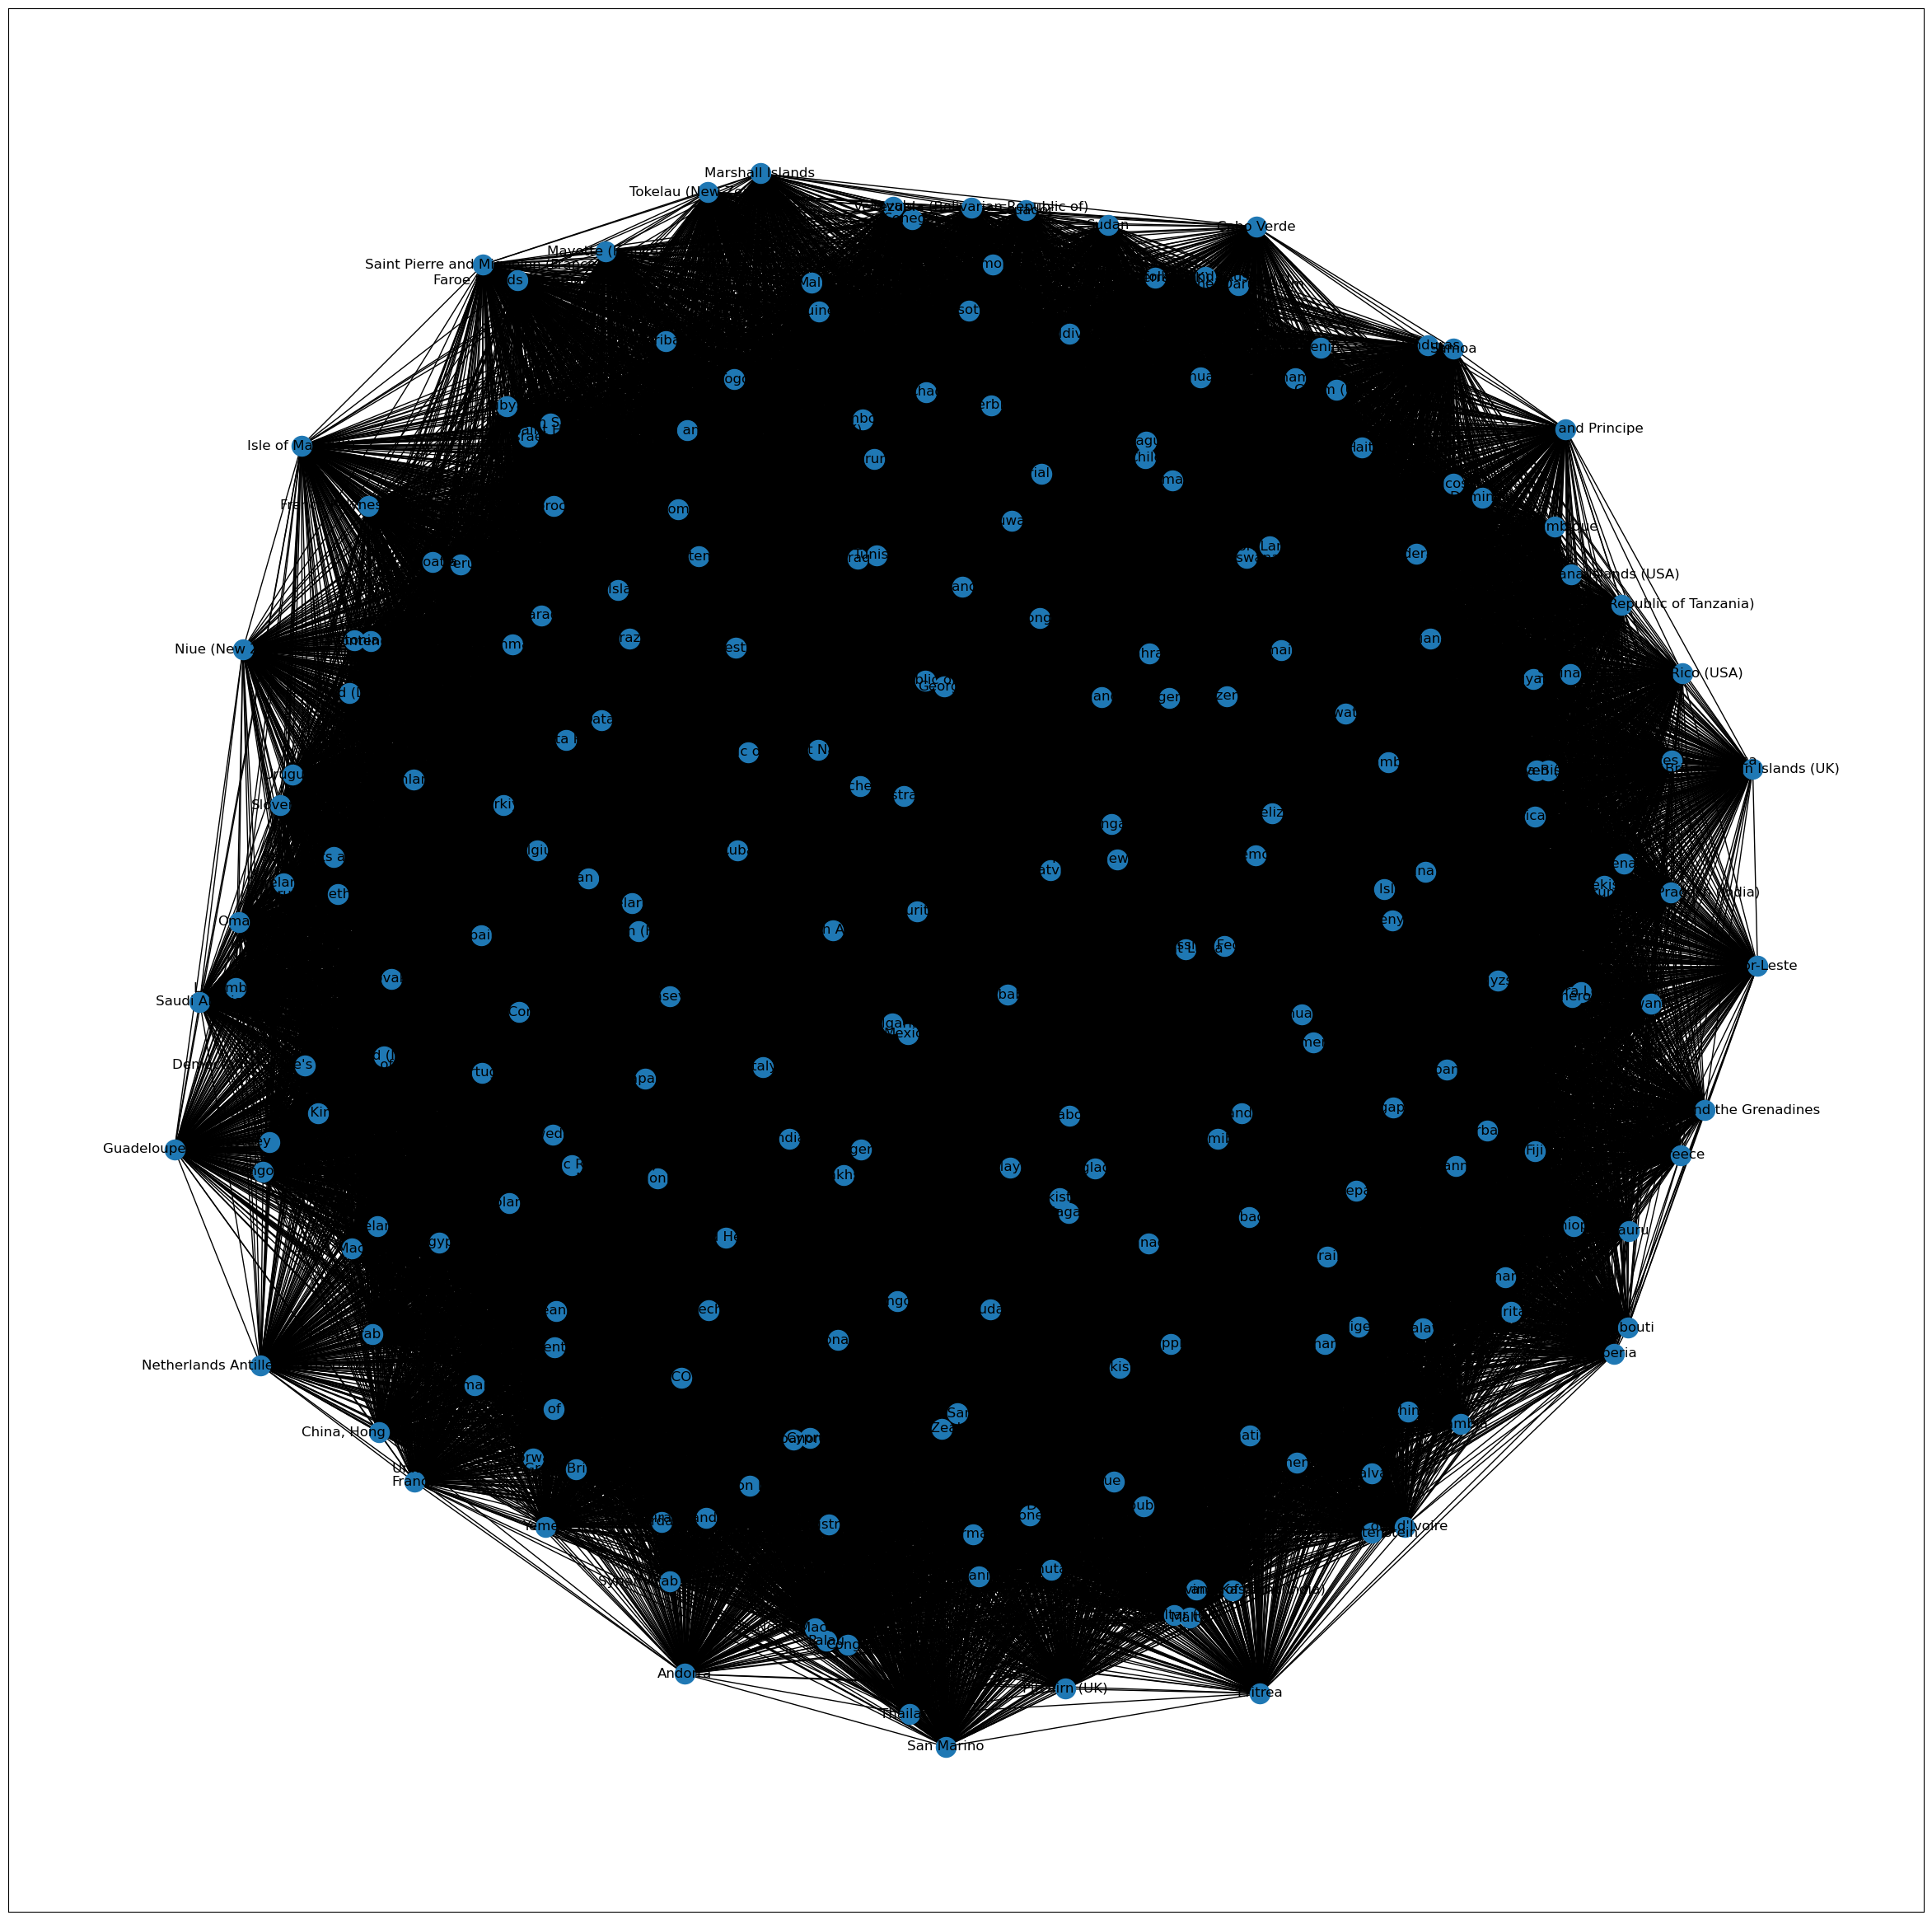

In [39]:
G = nx.Graph()

size = country_co_occurrence.shape[0]

countries_swap_copy = countries_swap.copy()

G.add_nodes_from(range(size))

for i in range(size):
        for j in range(i+1, size):
            if country_co_occurrence[i, j] != 0.0:
            #if country_co_ocurrence[i, j] > 0.002:
                G.add_edge(i, j, weight=country_co_occurrence[i, j])

for i in range(size):
    if np.sum(country_co_occurrence[i])==0:
        G.remove_node(i)
        countries_swap_copy.pop(i)

plt.figure(figsize=(30, 30))
nx.draw_networkx(G, labels=countries_swap_copy,with_labels=True)
#nx.draw_spring(G, labels=countries_swap,with_labels=True)

# Community detection

In [40]:
from networkx.algorithms.community import louvain_communities
comms = louvain_communities(G,weight="weight",resolution=1.3,seed=69)
unique_coms = np.unique(list(comms))

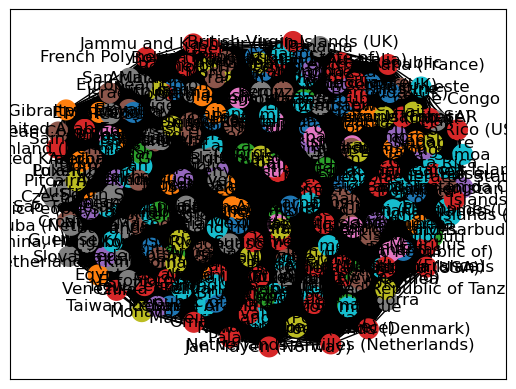

In [41]:
community_assignment = {}

# Assign community indices to nodes
for i, community in enumerate(comms):
    for node in community:
        community_assignment[node] = i

# Create a list of colors for each node based on the community assignment
node_colors = [community_assignment.get(node, -1) for node in G.nodes()]

# Draw the graph with different colors for different communities
pos = nx.spring_layout(G)  # Positions of nodes in the graph layout
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=200)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos,labels=countries_swap_copy)
plt.show()


In [56]:
# print out communities
comms = louvain_communities(G,weight="weight",resolution=1.1796,seed=69)
unique_coms = np.unique(list(comms))
i=1
communities={}
for community in comms:
        print("c",i)
        com_countries = []
        for c in community:
            print(countries_swap[c])
            com_countries.append(c)
        communities[i] = com_countries
        i=i+1


c 1
Puerto Rico (USA)
Paraguay
c 2
Cayman Islands (UK)
Bahamas
Guam (USA)
Jamaica
Micronesia (Federated States of)
Lithuania
Montserrat (UK)
American Samoa (USA)
Singapore
Turks and Caicos Islands (UK)
Mauritius
Zanzibar (United Republic of Tanzania)
Namibia
Guyana
Dominica
Norfolk Island (Australia)
Bahrain
Bermuda (UK)
Barbados
Vanuatu
Samoa
Northern Mariana Islands (USA)
Antigua and Barbuda
Fiji
c 3
Malawi
Zimbabwe
Eswatini
Botswana
Kenya
c 4
South Africa
Saint Helena, Ascension and Tristan da Cunha (UK)
c 5
Eritrea
Taiwan Province of China
China
Thailand
c 6
Seychelles
c 7
Madeira Islands (Portugal)
Ecuador
Israel
Brazil
Dominican Republic
China, Macao SAR
Brunei Darussalam
Pakistan
Nicaragua
Peru
Honduras
Denmark
El Salvador
Cabo Verde
Mozambique
Panama
Philippines
Angola
Cuba
Timor-Leste
Colombia
Costa Rica
Serbia
Venezuela (Bolivarian Republic of)
c 8
Mexico
Oman
c 9
Gibraltar (UK)
French Polynesia (France)
Finland
Andean Community
North Macedonia
Cyprus
San Marino
Netherlands (